# Search using BoW

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import hog
from skimage import data, exposure
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.transform import resize

from keras.preprocessing import image

import pandas as pd

# Hide all warnings
import warnings
warnings.filterwarnings('ignore')

print (os.getcwd(), "changing to:", os.getcwd()+"/../")

# Change this according to the path where you have the ws_toolkit
ws_toolkit_path = os.getcwd()+"/.."

os.chdir(ws_toolkit_path)
print (os.getcwd())

from ws_toolkit.utils import center_crop_image

import nltk

df = pd.read_csv("./visualstories_edfest_2016_twitter_xmedia.csv", sep=';', encoding="utf-8")

data = np.array([df.get("text").values, df.get("image-url").values])
tweets = data[0]
imageLinks = data[1]

# Bad resulsts
#from nltk.tokenize import TreebankWordTokenizer
#tknzr = TreebankWordTokenizer()

# Good results but doesn't have method to remove links
#from nltk.tokenize import TweetTokenizer
#tknzr = TweetTokenizer(strip_handles=True, preserve_case=False)

# Very Good Resulsts, probably because urls and handles are removed
from tokenizer import tokenizer
tknzr = tokenizer.TweetTokenizer(preserve_handles=False, preserve_case=False, preserve_url=False)

from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

def k_neighbours(q, X, metric="euclidean", k=10):
    # Check pairwise_distances function docs: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances
    dists = pairwise_distances(q, X, metric=metric)
    
    # Dists gets a shape 1 x NumDocs. Convert it to shape NumDocs (i.e. drop the first dimension)
    dists = np.squeeze(dists)
    sorted_indexes = np.argsort(dists)
    
    return sorted_indexes[:k], dists[sorted_indexes[:k]]

def init_bow(texts, tknzr):
    vectorizer = CountVectorizer(stop_words="english", min_df=3, binary=False, tokenizer=tknzr.tokenize)
    texts_bow = vectorizer.fit_transform(tweets)
    vocabulary = vectorizer.vocabulary_
    #print("Vocabulary size: {}".format(len(vocabulary)))
    texts_bow = normalize(texts_bow, norm="l2")
    
    return vectorizer, texts_bow

def bow_query(vectorizer, query):
    # Transform query in a BoW representation
    query_bow = vectorizer.transform([query])
    query_bow = normalize(query_bow, norm="l2")
    
    return query_bow

def center_crop_image(im, size=224):

    if len(im.shape) >= 3 and im.shape[2] == 4: # Remove the alpha channel when present
        im = im[:, :, 0:3]

    # Resize so smallest dim = 224, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = resize(image=im, output_shape=(224, int(w * 224 / h)))
    else:
        im = resize(im, (int(h * 224 / w), 224))

    # Center crop to 224x224
    h, w, _ = im.shape
    im = im[h // 2 - 112:h // 2 + 112, w // 2 - 112:w // 2 + 112]
    
    return im

def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10,6)):

    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        img = center_crop_image(imread(list_of_images[i]))
        plt.imshow(img)
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

def print_results(results):
    for r in results:
        print("{0}".format(r[2]))
        img = imread(r[3].replace('https://pbs.twimg.com/media/', './images/'))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    # results = np.array(results)
    # grid_display([r.replace('https://pbs.twimg.com/media/', '../images/') for r in results[:,3]], results[:,2], 1)

Using TensorFlow backend.


/Users/franciscorodrigues/Projects/pw_phase1/project changing to: /Users/franciscorodrigues/Projects/pw_phase1/project/../
/Users/franciscorodrigues/Projects/pw_phase1


In [2]:
vectorizer, texts_bow = init_bow(tweets, tknzr)

query = "Edinburgh Castle is one of the main attractions"
query_bow = bow_query(vectorizer, query)

k_nearest_indexes, k_nearest_dists = k_neighbours(q=query_bow, X=texts_bow, metric="cosine", k=10)

results = list(zip(k_nearest_indexes,k_nearest_dists, [tweets[i] for i in k_nearest_indexes],[imageLinks[i] for i in k_nearest_indexes]))

## Original Query

In [3]:
print("{0}\n".format(query))

Edinburgh Castle is one of the main attractions



## Results

Edinburgh castle overlooking grassmarket #edfringe pic.twitter.com/K4M7fmcPXe


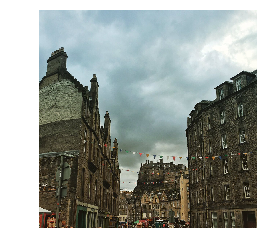

Castle show kicks off Edinburgh festival http://dlvr.it/LzMv9x pic.twitter.com/L4gugHwK0p


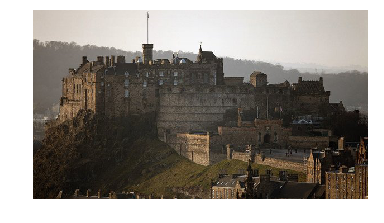

Beautiful Edinburgh Castle  #edfringe #scotlandpic.twitter.com/BncX39N619


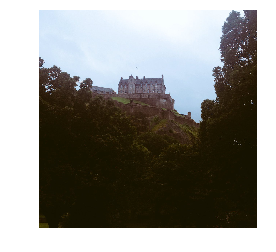

This week's cultural light show courtesy of Edinburgh Castle #edfest pic.twitter.com/egGaouUhpD


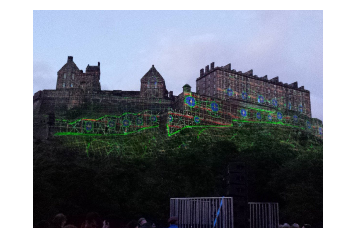

Edinburgh Castle #DeepTime #Edinburgh #edfest via http://ift.tt/1qC8Qxm pic.twitter.com/qVGNuCTDlc


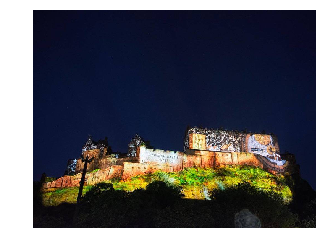

Photo from digital light show @ Edinburgh Castle last night marking the opening of 2016 Edinburgh Festival #DeepTimepic.twitter.com/bVoSjcAP1u


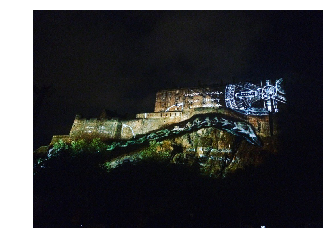

All done for 2016 #EdFringe pic.twitter.com/bPdlqYo5yB – em Edinburgh Castle


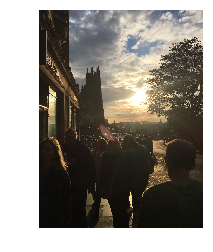

Good but cold times @EdinburghTattoo The castle looked a wee bit like wedding cake. @edinburghfest pic.twitter.com/8wHjFSbHOk – em Edinburgh Castle


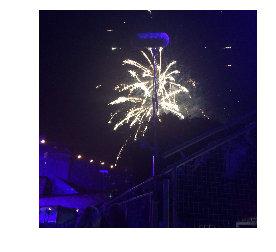

Fireworks at Edinburgh Castle end ace first day at #edfest with @thomasfoster_ https://instagram.com/p/BI8cPXVBA7F/ pic.twitter.com/YjDbvvPcra


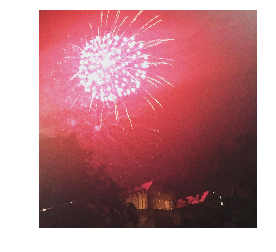

Waiting for the Deep Time opening event for Edinburgh Festival 2016 #deeptime #EdinburghFestival pic.twitter.com/4Lssa96txA – em Edinburgh Castle


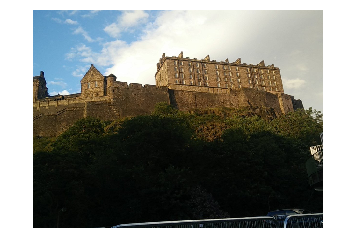

In [4]:
print_results(results)

# Search using Histogram of Colors (HoC)

Shape of feature matrix: (2000, 64)
Image query feature dimension: (64,)
Query image: 765986455512645632.jpg


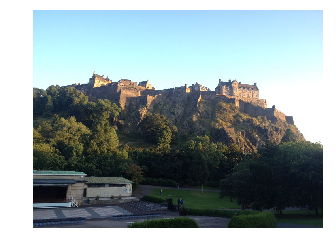

Image #0 - distance: 0.07163851175564012


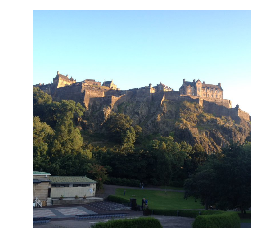

Image #1 - distance: 0.44409429267919603


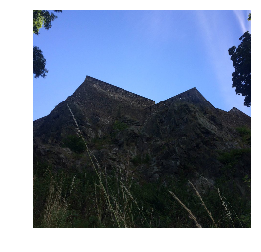

Image #2 - distance: 0.47564874585489036


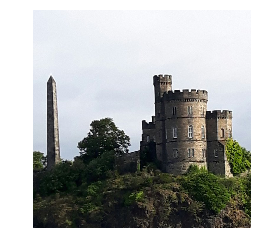

Image #3 - distance: 0.4940620471059254


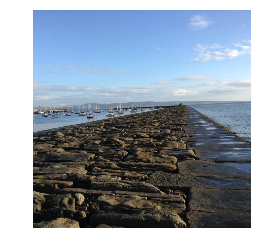

Image #4 - distance: 0.506495374013683


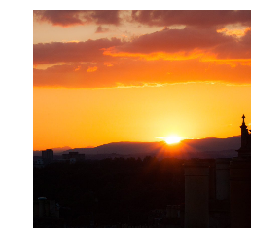

Image #5 - distance: 0.5453480295801328


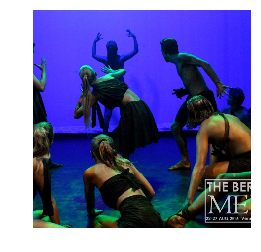

Image #6 - distance: 0.5478043099596315


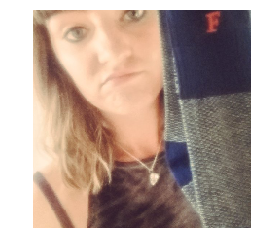

Image #7 - distance: 0.5675202283769873


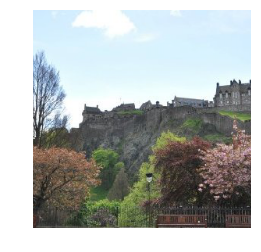

Image #8 - distance: 0.5735634501773814


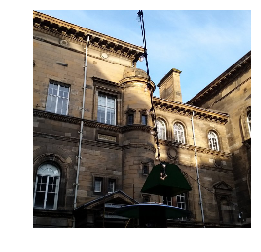

Image #9 - distance: 0.5741395946792119


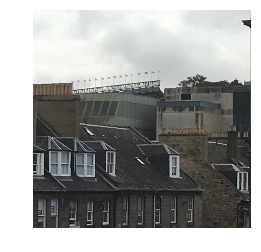

In [5]:
from skimage import img_as_ubyte
from sklearn.preprocessing import normalize
from skimage import color

def hoc(im, bins=(16,16,16), hist_range=(256, 256, 256)):
    im_r = im[:,:,0]
    im_g = im[:,:,1]
    im_b = im[:,:,2]
    
    red_level = hist_range[0] / bins[0]
    green_level = hist_range[1] / bins[1]
    blue_level = hist_range[2] / bins[2]
    
    im_red_levels = im_r / red_level
    im_green_levels = im_g / green_level
    im_blue_levels = im_b / blue_level
    
    ind = im_blue_levels*bins[0]*bins[1]+ im_green_levels*bins[0] + im_red_levels
    
    hist_r, bins_r = np.histogram(ind.flatten(), bins[0]*bins[1]*bins[2])
    
    return hist_r, bins_r

#Histogram of colors results
feats = []

#Test with diferent bins
bins=(4,4,4)

for img in imageLinks:
    
    #Alter image links to images folder
    img = imread(img.replace('https://pbs.twimg.com/media/', './images/'))
    
    # resize image
    img = center_crop_image(img, size=224)
    
    # Change image color space from RGB to HSV. 
    # HSV color space was designed to more closely align with the way human vision perceive color-making attributes
    img = color.rgb2hsv(img)
    
    # convert image pixels to [0, 255] range, and to uint8 type
    img_int = img_as_ubyte(img)

    # Extract HoC features
    hist, bin_edges = hoc(img_int, bins=bins)
    
    # Normalize features
    # We add 1 dimension to comply with scikit-learn API
    hist = np.squeeze(normalize(hist.reshape(1, -1), norm="l2"))
    
    feats.append(hist)
    
# Creating a feature matrix for all images
feats = np.array(feats)

print("Shape of feature matrix: {}".format(feats.shape))

# Prepare image query
# try the following: image 11, image12, image13
image_q = "765986455512645632.jpg"

img_q = imread("./query_images/" + image_q)
img_q_hsv = color.rgb2hsv(img_q)
img_q_hsv = center_crop_image(img_q_hsv, size=224)
img_int = img_as_ubyte(img_q_hsv)
hist, bin_edges = hoc(img_int, bins=bins)

image_q_feat = np.squeeze(normalize(hist.reshape(1, -1), norm="l2"))
print("Image query feature dimension: {}".format(image_q_feat.shape))

# Use the implemented function to find the K nearest neighbours on the HoC image vector space.
k_nearest_indexes, k_nearest_dists = k_neighbours(q=image_q_feat.reshape(1,-1), X=feats, metric="euclidean", k=10)

# Inspecting the top-k results - list of tuples (image index, distance to query image, image name)
list(zip(k_nearest_indexes, k_nearest_dists, [imageLinks[i] for i in k_nearest_indexes]))

print("Query image: {}".format(image_q))
plt.imshow(img_q)
plt.axis('off')
plt.show()

for i, (img_idx, img_dist) in enumerate(zip(k_nearest_indexes,k_nearest_dists)):
    image_fname = imageLinks[img_idx]
    img = imread(image_fname.replace('https://pbs.twimg.com/media/', './images/'))
    img = center_crop_image(img, size=224)
    print("Image #{} - distance: {}".format(i, img_dist))
    plt.imshow(img)
    plt.axis('off')
    plt.show()